simulation completed ...


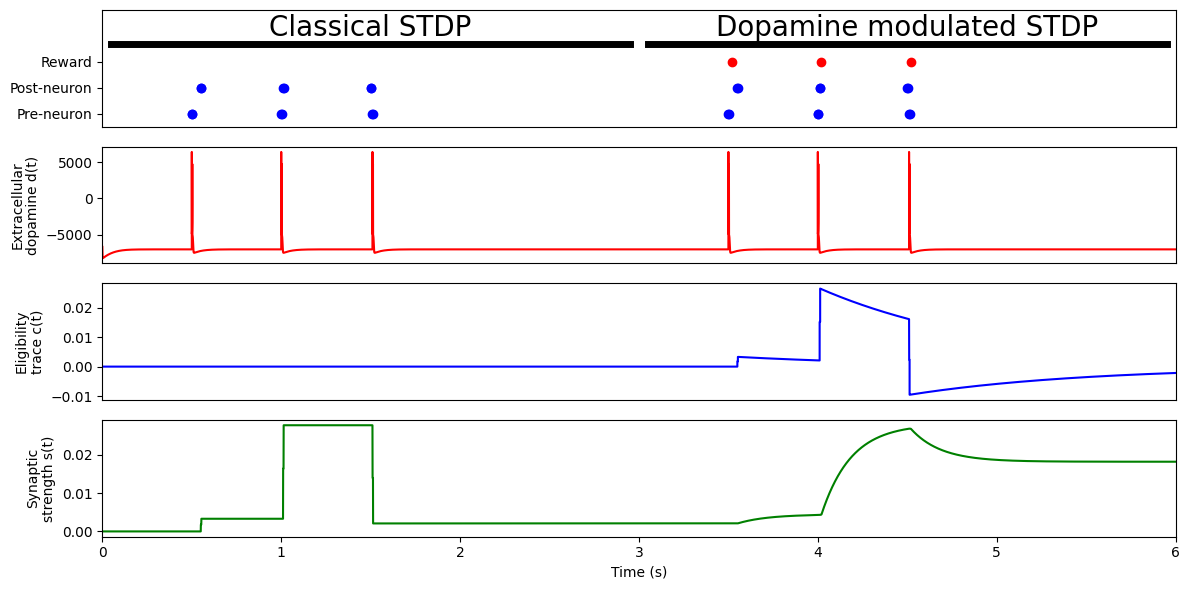

In [6]:
from brian2 import *

# Parameters
simulation_duration = 6 * second

## Neurons
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

tfinal = 1000 * ms
Ne = 800
Ni = 200

## STDP
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

## Dopamine signaling
tauc = 1000*ms
taud = 200*ms
taus = 1*ms
epsilon_dopa = 5e-3

# Setting the stage

## Stimuli section
input_indices = array([0, 1, 0, 1, 1, 0,
                       0, 1, 0, 1, 1, 0])
input_times = array([ 500,  550, 1000, 1010, 1500, 1510,
                     3500, 3550, 4000, 4010, 4500, 4510])*ms
spike_input = SpikeGeneratorGroup(2, input_indices, input_times)

#neurons = NeuronGroup(2, '''dv/dt = (ge * (Ee-v) + El - v) / taum : 1
#                            dge/dt = -ge / taue : 1''',
#                      threshold='v>vt', reset='v = vr',
#                      method='exact')
#neurons.v = vr


eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         I_noise : 1
         a : 1
         b : 1
         cn : 1
         dn : 1
       """

N = NeuronGroup(Ne + Ni, eqs, threshold="v>=30", reset="v=cn; u+=dn", method="euler")
N.v = -65

##spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=0, when='after_thresholds')
N.a = 0.02
N.b = 0.2
N.cn = -65 + 15
N.dn = 8 - 6

neurons_monitor = SpikeMonitor(N)

synapse = Synapses(spike_input, N,
                   model='''s: 1''',
                   on_pre='v += s')
synapse.connect(i=[0, 1], j=[0, 1])
synapse.s = 100

## STDP section
synapse_stdp = Synapses(N, N,
                   model='''mode: 1
                         dc/dt = -c / tauc : 1 (clock-driven)
                         dd/dt = -d / taud : 1 (clock-driven)
                         ds/dt = mode * c * d / taus : 1 (clock-driven)
                         dApre/dt = -Apre / taupre : 1 (event-driven)
                         dApost/dt = -Apost / taupost : 1 (event-driven)''',
                    ## v += s works, while I+=s has too many spikes
                   on_pre='''v += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                   on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                   method='euler'
                   )
synapse_stdp.connect(i=0, j=1)
synapse_stdp.mode = 0
synapse_stdp.s = 1e-10
synapse_stdp.c = 1e-10
synapse_stdp.d = 0
synapse_stdp_monitor = StateMonitor(synapse_stdp, ['s', 'c', 'd'], record=[0])

## Dopamine signaling section
dopamine_indices = array([0, 0, 0])
dopamine_times = array([3520, 4020, 4520])*ms
dopamine = SpikeGeneratorGroup(1, dopamine_indices, dopamine_times)
dopamine_monitor = SpikeMonitor(dopamine)
reward = Synapses(dopamine, synapse_stdp, model='''''',
                            on_pre='''d_post += epsilon_dopa''',
                            method='exact')
reward.connect()

# Simulation
## Classical STDP
synapse_stdp.mode = 0
run(simulation_duration/2)
## Dopamine modulated STDP
synapse_stdp.mode = 1
run(simulation_duration/2)
print('simulation completed ...')

# Visualisation
dopamine_indices, dopamine_times = dopamine_monitor.it
neurons_indices, neurons_times = neurons_monitor.it
figure(figsize=(12, 6))
subplot(411)
plot([0.05, 2.95], [2.7, 2.7], linewidth=5, color='k')
text(1.5, 3, 'Classical STDP', horizontalalignment='center', fontsize=20)
plot([3.05, 5.95], [2.7, 2.7], linewidth=5, color='k')
text(4.5, 3, 'Dopamine modulated STDP', horizontalalignment='center', fontsize=20)
plot(neurons_times, neurons_indices, 'ob')
plot(dopamine_times, dopamine_indices + 2, 'or')
xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])
xticks([])
subplot(412)
#plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.d.T/gmax, 'r-')
plot(synapse_stdp_monitor.t/second, statemon.v.T/gmax, 'r-')
xlim([0, simulation_duration/second])
ylabel('Extracellular\ndopamine d(t)')
xticks([])
subplot(413)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility\ntrace c(t)')
xticks([])
subplot(414)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')
tight_layout()
show()
